In [1]:
from vit_prisma.visualization.visualize_attention import plot_attn_heads
from vit_prisma.utils.get_activations import get_activations, ActivationCacheHook, CustomAttention

from vit_prisma.models.base_vit import BaseViT
from vit_prisma.configs.InductionConfig import GlobalConfig

from vit_prisma.dataloaders.induction import InductionDataset

import torch

import copy

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load original model
checkpoint = 0
checkpoint_path = f'/network/scratch/s/sonia.joseph/vit_prisma/induction/1_layer_attn_only/checkpoints'
file_name = 'model_{checkpoint}.pth'

config = GlobalConfig()
orig_model = BaseViT(config)
state_dict = torch.load(os.path.join(checkpoint_path, file_name), map_location=torch.device('cpu'))['model_state_dict']
orig_model.load_state_dict(state_dict)

# Replace original model's attention with hooked attention
model = copy.deepcopy(orig_model)
for idx, block in enumerate(model.blocks):
    model.blocks[idx].attention = CustomAttention(config)

# Reset attention with pretrained weights from original model.
model.load_state_dict(orig_model.state_dict())

# Load dataset
testset = InductionDataset('test')
testloader = torch.utils.data.DataLoader(testset)

Loading induction dataset from cache... ../data/induction/all_test.npz


In [3]:
# Get activations for all layers
dataloader  = testloader
total_activations = []
for idx, block in enumerate(model.blocks):
    print("On block {}".format(idx))
    activations = get_activations(model, model.blocks[idx].attention.attn_scores, dataloader, max_count=200, use_cuda=False)
    total_activations.append(activations)

print("Shape of activations per layer: {}".format(activations.shape))

On block 0


 30%|███       | 200/656 [00:15<00:35, 12.69it/s]

Shape of activations per layer: (201, 4, 17, 17)


Total Min: -0.114928238093853, Total Max: 0.12261349707841873


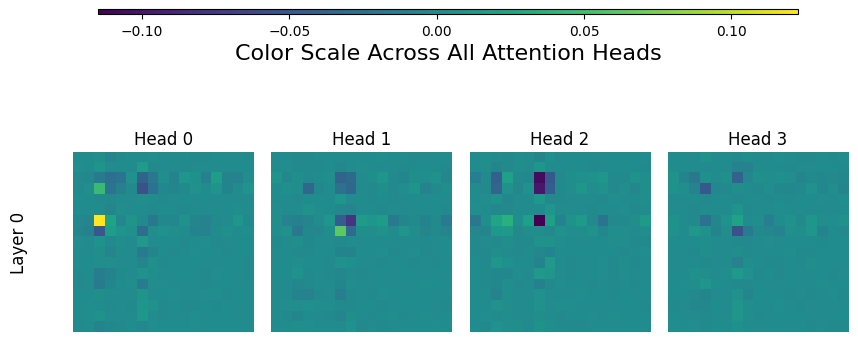

(4, 17, 17)
Total Min: -0.010892526246607304, Total Max: 0.010895407758653164


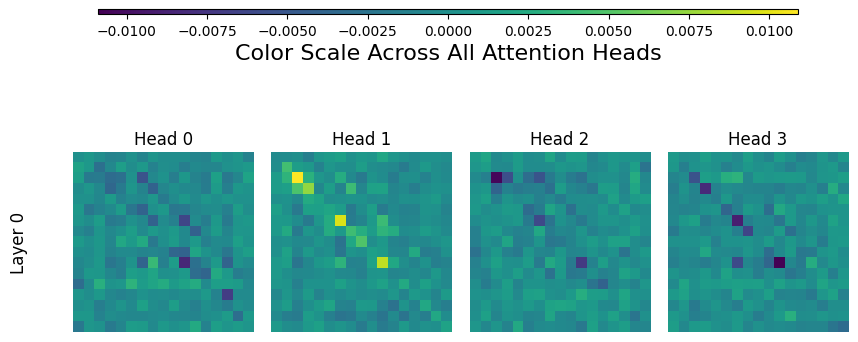

In [9]:
plot_attn_heads(total_activations, idx=10, img_shape=17, global_min_max=True)

# Get average activations across heads for first layer
average_activations = np.mean(total_activations[0], axis=0)
print(average_activations.shape)

plot_attn_heads([average_activations[np.newaxis, :]], idx=0,  img_shape=17, global_min_max=True)

In [10]:
# Function that goes through checkpoints and plots each attention head

activations_all_cp = []
for f in os.listdir(checkpoint_path):
    print(f)

NotADirectoryError: [Errno 20] Not a directory: '/network/scratch/s/sonia.joseph/vit_prisma/induction/1_layer_attn_only/checkpoints/model_0.pth'